# **Модель, которая обучалась только на фингерпринтах MACCS**

In [ ]:
data = pd.read_csv('data/result_fingerprint_maccs.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
target_col = 'score'

X = data.drop(columns=[target_col])
y = data[target_col]

**Настройка одинакового распределения таргета по двум выборкам**

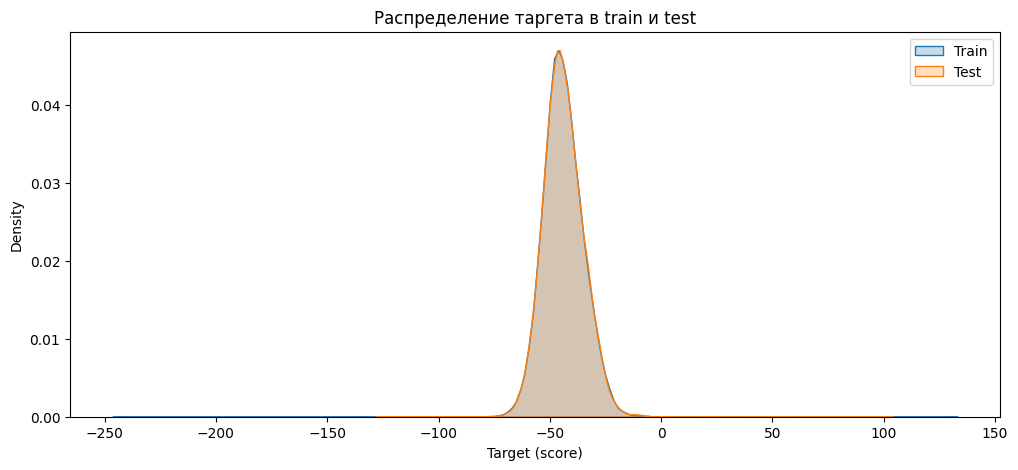

Размер обучающей выборки: 71657
Размер тестовой выборки: 17915


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

n_bins = 10
y_binned = pd.qcut(y, q=n_bins, labels=False)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y_binned
)

plt.figure(figsize=(12,5))
sns.kdeplot(y_train, label='Train', fill=True)
sns.kdeplot(y_test, label='Test', fill=True)
plt.xlabel("Target (score)")
plt.ylabel("Density")
plt.title("Распределение таргета в train и test")
plt.legend()
plt.show()

# 4. Выводим размеры выборок
print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

**Подбор гиперпараметро**в

In [ ]:
import optuna
import xgboost as xgb
import numpy as np
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 300, 500, 1000]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0, log=True),
        'random_state': 0
    }


    model = xgb.XGBRegressor(**params)

    scores = cross_val_score(
        model,
        X_train,
        y_train,
        scoring="neg_mean_squared_error",
        cv=5
    )

    return -np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Лучшие гиперпараметры:", study.best_params)

[I 2025-09-20 19:40:57,072] A new study created in memory with name: no-name-8cf4f62b-4066-4539-96aa-91d72bf173fd
[I 2025-09-20 19:41:50,387] Trial 0 finished with value: 32.64092749254881 and parameters: {'n_estimators': 100, 'learning_rate': 0.11823443669771648, 'max_depth': 7, 'min_child_weight': 8, 'gamma': 0.8410838627624301, 'subsample': 0.9321831190006629, 'colsample_bytree': 0.7026931542677379, 'reg_lambda': 0.15335098050425963, 'reg_alpha': 0.18189182855657543}. Best is trial 0 with value: 32.64092749254881.
[I 2025-09-20 19:42:20,783] Trial 1 finished with value: 41.605463309001834 and parameters: {'n_estimators': 100, 'learning_rate': 0.025093792470961544, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 0.01108943783377896, 'subsample': 0.94336566485281, 'colsample_bytree': 0.8413216066168044, 'reg_lambda': 0.24979735468597328, 'reg_alpha': 0.06756227185348776}. Best is trial 0 with value: 32.64092749254881.
[I 2025-09-20 19:42:45,079] Trial 2 finished with value: 36.503325

Лучшие гиперпараметры: {'n_estimators': 1000, 'learning_rate': 0.02712755633243102, 'max_depth': 9, 'min_child_weight': 4, 'gamma': 0.13743041530869918, 'subsample': 0.8591283246856937, 'colsample_bytree': 0.7276147218655173, 'reg_lambda': 0.025340479077461713, 'reg_alpha': 0.23072965607483634}


**Обучение модели**

Train MSE : 10.7836
Test  MSE : 28.2893
Train RMSE: 3.2838
Test  RMSE: 5.3188
Train MAE : 2.4027
Test  MAE : 3.8638
Train R^2 : 0.8725
Test  R^2 : 0.6583

Cross-Validation:
Mean R^2 : 0.6584 ± 0.0063
Mean RMSE: 5.3753 ± 0.0474


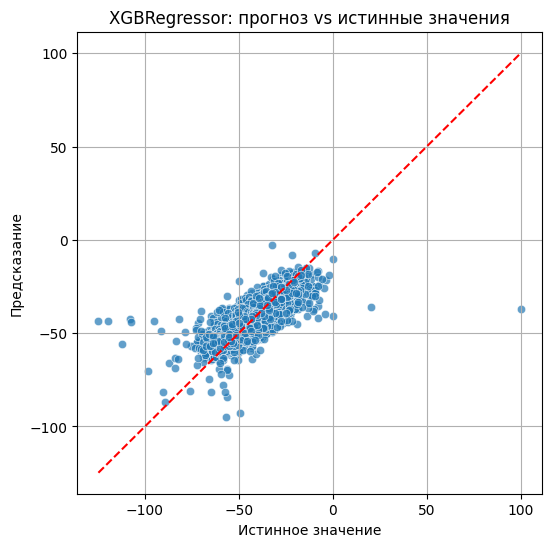

Размер обучающей выборки: (71657, 167)
Размер тестовой выборки : (17915, 167)
Модель сохранена в model_xgb_regression_FING.pkl


In [ ]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import joblib

# Преобразуем y в одномерные массивы
y_train_array = y_train.values.ravel()
y_test_array  = y_test.values.ravel()

# Параметры модели
best_params = {
    'n_estimators': 1000,
    'learning_rate':  0.02712755633243102,
    'max_depth': 9,
    'min_child_weight': 4,
    'gamma': 0.13743041530869918,
    'subsample':  0.8591283246856937,
    'colsample_bytree': 0.7276147218655173,
    'reg_lambda': 0.025340479077461713,
    'reg_alpha': 0.23072965607483634,
    'random_state': 0,
}

# Создаем и обучаем модель
model_xgb = xgb.XGBRegressor(**best_params)
model_xgb.fit(X_train, y_train_array)

# Предсказания
y_train_pred = model_xgb.predict(X_train)
y_test_pred  = model_xgb.predict(X_test)

# Метрики
mse_train = mean_squared_error(y_train_array, y_train_pred)
mse_test  = mean_squared_error(y_test_array, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test  = np.sqrt(mse_test)
mae_train = mean_absolute_error(y_train_array, y_train_pred)
mae_test  = mean_absolute_error(y_test_array, y_test_pred)
r2_train  = r2_score(y_train_array, y_train_pred)
r2_test   = r2_score(y_test_array, y_test_pred)

print(f"Train MSE : {mse_train:.4f}")
print(f"Test  MSE : {mse_test:.4f}")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Test  RMSE: {rmse_test:.4f}")
print(f"Train MAE : {mae_train:.4f}")
print(f"Test  MAE : {mae_test:.4f}")
print(f"Train R^2 : {r2_train:.4f}")
print(f"Test  R^2 : {r2_test:.4f}")

# Кросс-валидация
cv_r2  = cross_val_score(model_xgb, X_train, y_train_array, cv=5, scoring='r2')
cv_rmse = -cross_val_score(model_xgb, X_train, y_train_array,
                           cv=5, scoring='neg_root_mean_squared_error')

print("\nCross-Validation:")
print(f"Mean R^2 : {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
print(f"Mean RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")

# График прогнозов vs истинные значения
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test_array, y=y_test_pred, alpha=0.7)
plt.plot([y_test_array.min(), y_test_array.max()],
         [y_test_array.min(), y_test_array.max()],
         color='red', linestyle='--')
plt.xlabel("Истинное значение")
plt.ylabel("Предсказание")
plt.title("XGBRegressor: прогноз vs истинные значения")
plt.grid()
plt.show()

# Размер выборок
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки : {X_test.shape}")

# Сохранение модели
joblib.dump(model_xgb, 'model_xgb_regression_FING.pkl')
print("Модель сохранена в model_xgb_regression_FING.pkl")


# **Модель, которая обучалась только на фингерпринтах MORGAN**

In [ ]:
data = pd.read_csv('data/result_fingerprint_morgan.csv')

In [ ]:
target_col = 'score'

X = data.drop(columns=[target_col])
y = data[target_col]

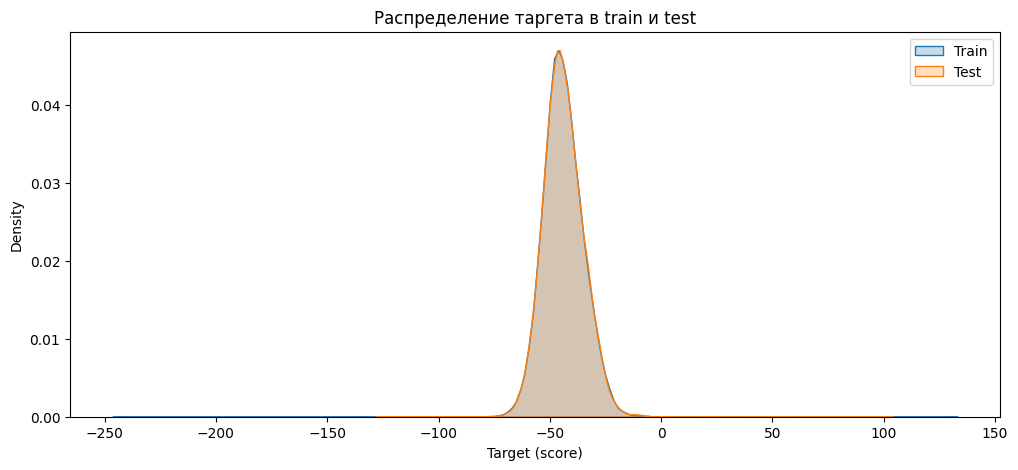

Размер обучающей выборки: 71657
Размер тестовой выборки: 17915


In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

n_bins = 10
y_binned = pd.qcut(y, q=n_bins, labels=False)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y_binned
)

plt.figure(figsize=(12,5))
sns.kdeplot(y_train, label='Train', fill=True)
sns.kdeplot(y_test, label='Test', fill=True)
plt.xlabel("Target (score)")
plt.ylabel("Density")
plt.title("Распределение таргета в train и test")
plt.legend()
plt.show()

print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

In [ ]:
import optuna
import xgboost as xgb
import numpy as np
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 300, 500, 1000]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0, log=True),
        'random_state': 0
    }


    model = xgb.XGBRegressor(**params)

    scores = cross_val_score(
        model,
        X_train,
        y_train,
        scoring="neg_mean_squared_error",
        cv=5
    )

    return -np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Лучшие гиперпараметры:", study.best_params)

[I 2025-09-21 11:52:48,694] A new study created in memory with name: no-name-328c6fda-da4a-4c21-88b2-9624ba82074d
[I 2025-09-21 12:00:03,809] Trial 0 finished with value: 29.144115794126048 and parameters: {'n_estimators': 1000, 'learning_rate': 0.29615910928983147, 'max_depth': 8, 'min_child_weight': 7, 'gamma': 0.05405759956205088, 'subsample': 0.7238403426539378, 'colsample_bytree': 0.8738352930117708, 'reg_lambda': 0.016144676688654817, 'reg_alpha': 0.04044735132732438}. Best is trial 0 with value: 29.144115794126048.
[I 2025-09-21 12:01:27,955] Trial 1 finished with value: 32.109662803964504 and parameters: {'n_estimators': 100, 'learning_rate': 0.08442217323839181, 'max_depth': 8, 'min_child_weight': 8, 'gamma': 0.9578242129745747, 'subsample': 0.9289013526664922, 'colsample_bytree': 0.6316655341251426, 'reg_lambda': 0.227878934346643, 'reg_alpha': 0.019232148723796794}. Best is trial 0 with value: 29.144115794126048.
[I 2025-09-21 12:04:13,755] Trial 2 finished with value: 29.93

Лучшие гиперпараметры: {'n_estimators': 1000, 'learning_rate': 0.10368306104440306, 'max_depth': 8, 'min_child_weight': 9, 'gamma': 0.08012729161891835, 'subsample': 0.9613359935543762, 'colsample_bytree': 0.5002644024740448, 'reg_lambda': 0.017623303611077813, 'reg_alpha': 0.3524327850559335}


Train MSE : 6.9144
Test  MSE : 23.8297
Train RMSE: 2.6295
Test  RMSE: 4.8816
Train MAE : 1.9927
Test  MAE : 3.5035
Train R^2 : 0.9183
Test  R^2 : 0.7122

Cross-Validation:
Mean R^2 : 0.7082 ± 0.0076
Mean RMSE: 4.9682 ± 0.0676


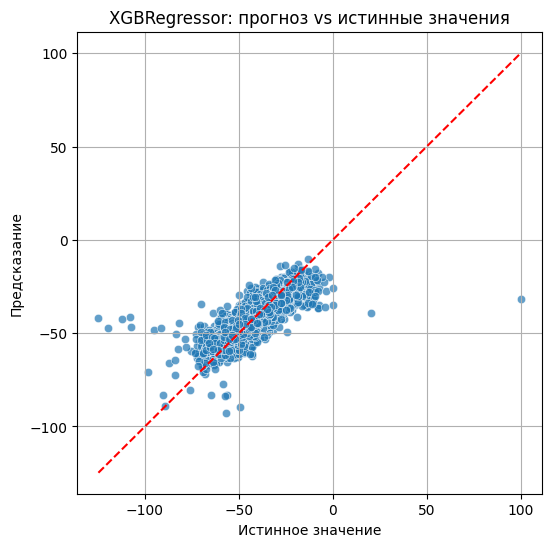

Размер обучающей выборки: (71657, 1024)
Размер тестовой выборки : (17915, 1024)


In [ ]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import joblib

y_train_array = y_train.values.ravel()
y_test_array  = y_test.values.ravel()

best_params = {
    'n_estimators': 1000,
    'learning_rate':  0.10368306104440306,
    'max_depth': 8,
    'min_child_weight': 9,
    'gamma':  0.08012729161891835,
    'subsample':  0.9613359935543762,
    'colsample_bytree': 0.5002644024740448,
    'reg_lambda': 0.017623303611077813,
    'reg_alpha': 0.3524327850559335,
    'random_state': 0,
}

model_xgb = xgb.XGBRegressor(**best_params)
model_xgb.fit(X_train, y_train_array)

y_train_pred = model_xgb.predict(X_train)
y_test_pred  = model_xgb.predict(X_test)

mse_train = mean_squared_error(y_train_array, y_train_pred)
mse_test  = mean_squared_error(y_test_array, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test  = np.sqrt(mse_test)
mae_train = mean_absolute_error(y_train_array, y_train_pred)
mae_test  = mean_absolute_error(y_test_array, y_test_pred)
r2_train  = r2_score(y_train_array, y_train_pred)
r2_test   = r2_score(y_test_array, y_test_pred)

print(f"Train MSE : {mse_train:.4f}")
print(f"Test  MSE : {mse_test:.4f}")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Test  RMSE: {rmse_test:.4f}")
print(f"Train MAE : {mae_train:.4f}")
print(f"Test  MAE : {mae_test:.4f}")
print(f"Train R^2 : {r2_train:.4f}")
print(f"Test  R^2 : {r2_test:.4f}")

# Кросс-валидация
cv_r2  = cross_val_score(model_xgb, X_train, y_train_array, cv=5, scoring='r2')
cv_rmse = -cross_val_score(model_xgb, X_train, y_train_array,
                           cv=5, scoring='neg_root_mean_squared_error')

print("\nCross-Validation:")
print(f"Mean R^2 : {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
print(f"Mean RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")

# График прогнозов vs истинные значения
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test_array, y=y_test_pred, alpha=0.7)
plt.plot([y_test_array.min(), y_test_array.max()],
         [y_test_array.min(), y_test_array.max()],
         color='red', linestyle='--')
plt.xlabel("Истинное значение")
plt.ylabel("Предсказание")
plt.title("XGBRegressor: прогноз vs истинные значения")
plt.grid()
plt.show()

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки : {X_test.shape}")

# # Сохранение модели
# joblib.dump(model_xgb, 'model_xgb_regression_FING.pkl')
# print("Модель сохранена в model_xgb_regression_FING.pkl")


# **Обучение модели на физико-химических и топологических признаках + 5 различных наборов данных**

In [ ]:
target_col = 'score'


X = data.drop(columns=[target_col])
y = data[target_col]

**Стандартизация величин**

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd


scaler = StandardScaler()

X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

print("Средние значения после стандартизации (≈0):")
print(X_scaled.mean().round(3).head())

print("\nСтандартные отклонения после стандартизации (≈1):")
print(X_scaled.std().round(3).head())

Средние значения после стандартизации (≈0):
MW_EXACT   -0.0
XLogP       0.0
HBA        -0.0
HBD        -0.0
TPSA_NO     0.0
dtype: float64

Стандартные отклонения после стандартизации (≈1):
MW_EXACT    1.0
XLogP       1.0
HBA         1.0
HBD         1.0
TPSA_NO     1.0
dtype: float64


**Удаление сильно коррелирующих величин с использованием коэффициента Спирмена**

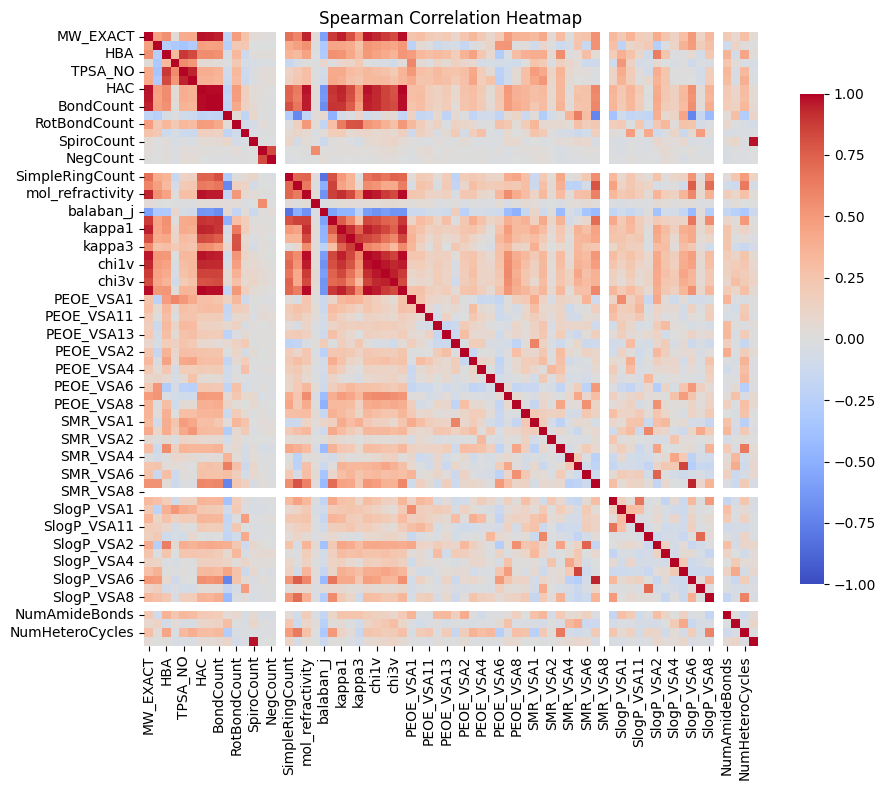

Оставшиеся признаки: ['MW_EXACT', 'XLogP', 'HBA', 'HBD', 'TPSA_NO', 'FSP3', 'RotBondCount', 'HalogenCount', 'SpiroCount', 'PosCount', 'NegCount', 'ComponentCount', 'SimpleRingCount', 'AromaticRingCount', 'formal_charge', 'balaban_j', 'kappa3', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'NumAmideBonds', 'NumAlifCarboxy', 'NumHeteroCycles']
Размер до: (89572, 70), после: (89572, 55)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

X_spearman = X_scaled.copy()

corr_spearman = X_spearman.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_spearman,
    annot=False,
    cmap="coolwarm",
    center=0,
    vmin=-1, vmax=1,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title("Spearman Correlation Heatmap")
plt.tight_layout()
plt.show()

upper = corr_spearman.where(np.triu(np.ones(corr_spearman.shape), k=1).astype(bool))

to_drop = [col for col in upper.columns if any(upper[col].abs() > 0.9)]

X_filtered = X_spearman.drop(columns=to_drop)

print("Оставшиеся признаки:", X_filtered.columns.tolist())
print(f"Размер до: {X_spearman.shape}, после: {X_filtered.shape}")

y_filtered = y.loc[X_filtered.index]

In [ ]:
import optuna
import xgboost as xgb
import numpy as np
from sklearn.model_selection import KFold, cross_val_score


X = X_filtered
y = y_filtered

def objective(trial):
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [100, 300, 500, 1000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.01, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 10.0, log=True),  # L2
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 1.0, log=True),    # L1
        "random_state": 42,
    }

    model = xgb.XGBRegressor(**params)


    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        model,
        X,
        y,
        scoring="neg_mean_squared_error",
        cv=cv,
        n_jobs=-1
    )
    return -np.mean(scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, n_jobs=-1)

print("Лучшие гиперпараметры:")
print(study.best_params)
print(f"Лучшее значение MSE: {study.best_value:.4f}")

[I 2025-09-22 13:47:44,022] A new study created in memory with name: no-name-819a2f49-9e3f-4264-b41f-fef6c487b7f1
[I 2025-09-22 13:51:32,334] Trial 1 finished with value: 23.263972702003112 and parameters: {'n_estimators': 300, 'learning_rate': 0.03355470070462153, 'max_depth': 10, 'min_child_weight': 10, 'gamma': 0.0760399610303914, 'subsample': 0.8742104268098143, 'colsample_bytree': 0.9071815451130696, 'reg_lambda': 1.8705731099860272, 'reg_alpha': 0.017802003758453464}. Best is trial 1 with value: 23.263972702003112.
[I 2025-09-22 13:51:48,519] Trial 0 finished with value: 23.587404299651446 and parameters: {'n_estimators': 1000, 'learning_rate': 0.013726436241819583, 'max_depth': 8, 'min_child_weight': 8, 'gamma': 0.01988933224196941, 'subsample': 0.555672671991855, 'colsample_bytree': 0.5854160279492667, 'reg_lambda': 9.161004162521657, 'reg_alpha': 0.0471924463021506}. Best is trial 1 with value: 23.263972702003112.
[I 2025-09-22 13:54:18,008] Trial 2 finished with value: 23.292

Лучшие гиперпараметры:
{'n_estimators': 1000, 'learning_rate': 0.0395176981566545, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 0.47199212799888357, 'subsample': 0.9690669172478878, 'colsample_bytree': 0.6444411688504517, 'reg_lambda': 7.069814923164525, 'reg_alpha': 0.7595172499320967}
Лучшее значение MSE: 22.1268


===== Результаты кросс-валидации =====
Средний R² : 0.737 ± 0.002
Средний RMSE: 4.704 ± 0.051
Средний MAE : 3.375 ± 0.023


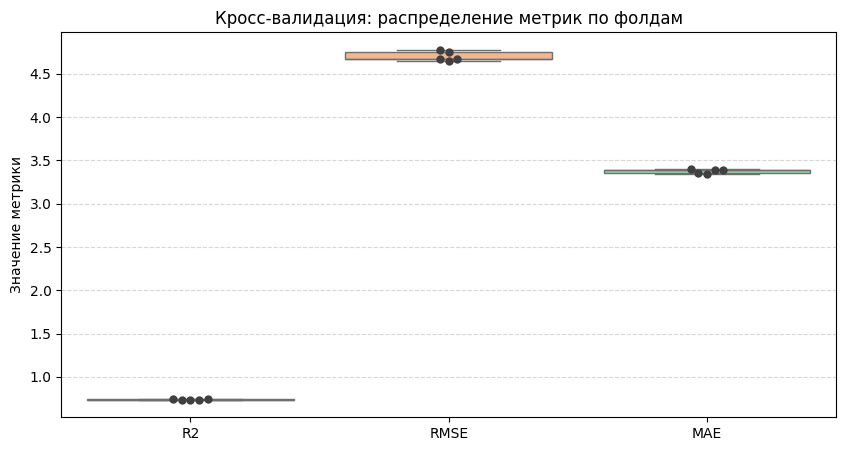

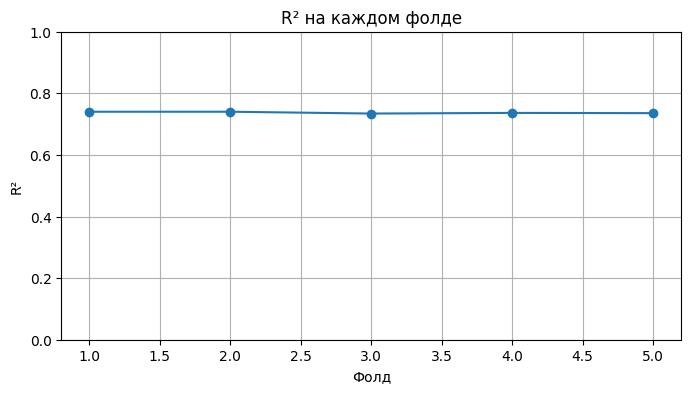

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb

best_params = study.best_params
best_params.update({'random_state': 42})

model = xgb.XGBRegressor(**best_params)
cv = KFold(n_splits=5, shuffle=True, random_state=42)


r2_scores = cross_val_score(model, X, y_array, cv=cv, scoring="r2")

rmse_scores = -cross_val_score(model, X, y_array, cv=cv,
                               scoring="neg_root_mean_squared_error")

mae_scores = -cross_val_score(model, X, y_array, cv=cv,
                              scoring="neg_mean_absolute_error")

print("===== Результаты кросс-валидации =====")
print(f"Средний R² : {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print(f"Средний RMSE: {rmse_scores.mean():.3f} ± {rmse_scores.std():.3f}")
print(f"Средний MAE : {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")



metrics_df = pd.DataFrame({
    "R2":   r2_scores,
    "RMSE": rmse_scores,
    "MAE":  mae_scores
})

plt.figure(figsize=(10, 5))
sns.boxplot(data=metrics_df, palette="pastel")
sns.swarmplot(data=metrics_df, color=".25", size=6)
plt.title("Кросс-валидация: распределение метрик по фолдам")
plt.ylabel("Значение метрики")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(range(1, cv.n_splits + 1), r2_scores, marker='o')
plt.title("R² на каждом фолде")
plt.xlabel("Фолд")
plt.ylabel("R²")
plt.ylim(0, 1)
plt.grid()
plt.show()
